In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
!wget https://raw.githubusercontent.com/vishalrk1/pytorch/main/Pytorch_Helper.py
from Pytorch_Helper import LabelEncoder, Tokenizer, Trainer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 64

max_length = 128

# Importing Data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

## Making csv files of Data

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:5]

In [ ]:
def preprocess_text_with_line_number(filename):
  """
  returns a list of dictionary of lines data
  
  """

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
    
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
       abstract_lines += line

  return abstract_samples


# getting data from file and preocess it
train_samples = preprocess_text_with_line_number(data_dir+'train.txt')
val_samples = preprocess_text_with_line_number(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_number(data_dir+'test.txt')

In [ ]:
# convertind dictionary lists into pandas dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

In [ ]:
train_df['target'].value_counts()

In [ ]:
plt.figure(figsize=(10,7))
sns.countplot('target',data=train_df);

## Preprocessing Data

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in paranthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub("[^A-Za-z0-9]+", " ", text) # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text


# Apply to dataframe
preprocessed_df = train_df.copy()
preprocessed_df.text = preprocessed_df.text.apply(preprocess)
print (f"{train_df.text.values[0]}\n\n{preprocessed_df.text.values[0]}")

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

## Spliting Data into train, test and validation dataset

In [ ]:
import collections
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 0.7
VAL_SIZE = 0.20
TEST_SIZE = 0.10

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Data
X = preprocessed_df["text"].values
y = preprocessed_df["target"].values

# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

# Label Encoding

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
print(NUM_CLASSES)

label_encoder.class_to_index

In [ ]:
class_names = label_encoder.class_to_index.keys()
class_names

In [ ]:
# Converting all targets into numbers
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)

In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

# Tokenizer

In [ ]:
tokenizer = Tokenizer(char_level=False, num_tokens=60000)

In [ ]:
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print(VOCAB_SIZE)

In [ ]:
from more_itertools import take

# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}")

[('<PAD>', 0), ('<UNK>', 1), ('patients', 2), ('group', 3), ('treatment', 4)]
least freq token's freq: 1


In [ ]:
# COnverting texts to sequence of numbers
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[0]

array([   71,   228,   244,   987,  7738,  3738, 27272,   232,   235])

## Padding Function

In [ ]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

# Trainer

In [ ]:
from tqdm.notebook import tqdm

class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None, save_path=None):
        
        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_path = save_path

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0
        acc = 0.0

        # Iterate over train batches
        for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)
            acc += self.calculate_accuracy(z, targets)

        return loss, acc

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        acc = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)
                acc += self.calculate_accuracy(z, y_true)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, acc, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_trues, y_probs = [], []
        acc = 0.0

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

                # Forward pass w/ inputs
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                acc += self.calculate_accuracy(z, targets)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true)
        
        acc = acc / len(dataloader)
        return acc, np.vstack(y_trues), np.vstack(y_probs)

    def calculate_accuracy(self, output, labels):
      output_class = torch.softmax(output, dim=1).argmax(dim=1)
      train_acc = (output_class == labels).sum().item()/len(output)
      return train_acc

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            print(f"<----- Epoch: {epoch+1} ----->")
            # Steps
            train_loss, train_acc = self.train_step(dataloader=train_dataloader)
            val_loss, val_acc, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                if self.save_path is not None:
                  print('Saving Model!!')
                  torch.save(self.model.state_dict(), self.save_path)
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            train_acc = train_acc / len(train_dataloader)
            val_acc = val_acc / len(val_dataloader)

            # Logging
            print(
                f"train Loss: {train_loss:.5f},\t"
                f"train Accuracy: {train_acc:.2f},\n"
                f"val Loss: {val_loss:.5f}, \t"
                f"val Accuracy: {val_acc:.2f}, \n"
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, \t"
                f"_patience: {_patience}"
                "\n"
            )
        return best_model

# Positional Encoding

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


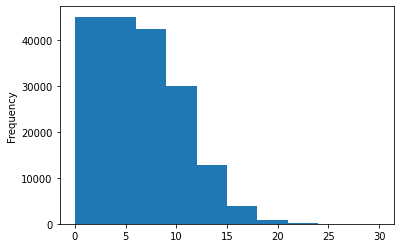

In [ ]:
train_df['line_number'].plot.hist();

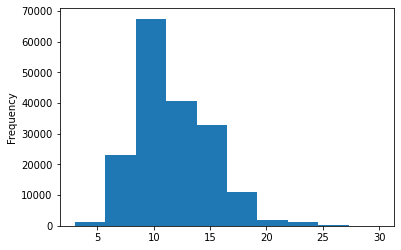

In [ ]:
train_df['total_lines'].plot.hist();

# Skimlit Dataset

In [ ]:
class SkimlitDataset(Dataset):
  def __init__(self, text_seq, target, line_num_one_hot, total_line_one_hot):
    self.text_seq = text_seq
    self.target = target
    self.line_num_one_hot = line_num_one_hot
    self.total_line_one_hot = total_line_one_hot

  def __len__(self):
    return len(self.target)

  def __str__(self):
    return f"<Dataset(N={len(self)})>"

  def __getitem__(self, index):
    X = self.text_seq[index]
    y = self.target[index]
    line_num = self.line_num_one_hot[index]
    total_line = self.total_line_one_hot[index]
    return [X, len(X), line_num, total_line, y]
  
  def collate_fn(self, batch):
    """Processing on a batch"""
    # Getting Input
    batch = np.array(batch)
    text_seq = batch[:,0]
    seq_lens = batch[:, 1]
    line_nums = batch[:, 2]
    total_lines = batch[:, 3]
    target = batch[:, 4]

    # padding inputs
    pad_text_seq = pad_sequences(sequences=text_seq) # max_seq_len=max_length

    # converting line nums into one-hot encoding
    line_nums = tf.one_hot(line_nums, depth=20)

     # converting total lines into one-hot encoding
    total_lines = tf.one_hot(total_lines, depth=24)

    # converting inputs to tensors
    pad_text_seq = torch.LongTensor(pad_text_seq.astype(np.int32))
    seq_lens = torch.LongTensor(seq_lens.astype(np.int32))
    line_nums = torch.tensor(line_nums.numpy())
    total_lines = torch.tensor(total_lines.numpy())
    target = torch.LongTensor(target.astype(np.int32))
    
    return pad_text_seq, seq_lens, line_nums, total_lines,  target

  def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
    dataloader = DataLoader(dataset=self, batch_size=batch_size, collate_fn=self.collate_fn, shuffle=shuffle, drop_last=drop_last, pin_memory=True)
    return dataloader


In [ ]:
# Creating Datasets
train_dataset = SkimlitDataset(text_seq=X_train, target=y_train, line_num_one_hot=train_df['line_number'], total_line_one_hot=train_df['total_lines'])
val_dataset = SkimlitDataset(text_seq=X_val, target=y_val, line_num_one_hot=val_df['line_number'], total_line_one_hot=val_df['total_lines'])
test_dataset = SkimlitDataset(text_seq=X_test, target=y_test, line_num_one_hot=test_df['line_number'], total_line_one_hot=test_df['total_lines'])

In [ ]:
train_dataset[0]

[array([   71,   228,   244,   987,  7738,  3738, 27272,   232,   235]),
 9,
 0,
 11,
 1]

In [ ]:
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1970, 422, 422)

In [ ]:
batch_text_seq, batch_seq_len, batch_line_num, batch_total_line, batch_target = next(iter(train_dataloader))

batch_line_num.shape, batch_total_line.shape, batch_line_num 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(torch.Size([64, 20]),
 torch.Size([64, 24]),
 tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

# Preparng Pretrained Embeddings

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2022-01-28 12:28:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-28 12:28:35 (79.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Downloading glove embeddings files
!wget http://nlp.stanford.edu/data/glove.6B.zip
unzip_data('/content/glove.6B.zip')

def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

--2022-01-28 12:28:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-28 12:28:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-28 12:28:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
EMBEDDING_DIM = 300
HIDDEN_DIM = 128

# Create embeddings
embeddings_file = '/content/glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)

embedding_matrix = make_embeddings_matrix(
    embeddings=glove_embeddings, word_index=tokenizer.token_to_index,
    embedding_dim=EMBEDDING_DIM)

print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=38752, dim=300)>


# Skimlit Model

In [ ]:
def gather_last_relevant_hidden(hiddens, seq_lens):
    """Extract and collect the last relevant
    hidden state based on the sequence length."""
    seq_lens = seq_lens.long().detach().cpu().numpy() - 1
    out = []
    for batch_index, column_index in enumerate(seq_lens):
        out.append(hiddens[batch_index, column_index])
    return torch.stack(out)

In [ ]:
class SkimlitModel(nn.Module):
  def __init__(self, embedding_dim, vocab_size, hidden_dim, n_layers, linear_output, num_classes, pretrained_embeddings=None, padding_idx=0):
    super(SkimlitModel, self).__init__()

    # Initalizing embeddings
    if pretrained_embeddings is None:
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
    else:
      pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
      self.embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, _weight=pretrained_embeddings, padding_idx=padding_idx)

    # LSTM layers
    self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)

    # FC layers
    self.fc_text = nn.Linear(2*hidden_dim, linear_output)

    self.fc_line_num = nn.Linear(20, 64)
    self.fc_total_line = nn.Linear(24, 64)

    self.fc_final = nn.Linear((64+64+linear_output), num_classes)
    self.dropout = nn.Dropout(0.3)

  def forward(self, inputs):
    x_in, seq_lens, line_nums, total_lines = inputs
    x_in = self.embeddings(x_in)

    # RNN outputs 
    out, b_n = self.lstm1(x_in)
    x_1 = gather_last_relevant_hidden(hiddens=out, seq_lens=seq_lens)

    # FC layers output
    x_1 = F.relu(self.fc_text(x_1))
    x_2 = F.relu(self.fc_line_num(line_nums))
    x_3 = F.relu(self.fc_total_line(total_lines))

    x = torch.cat((x_1, x_2, x_3), dim=1)
    x = self.dropout(x)
    x = self.fc_final(x)
    return x

In [ ]:
model = SkimlitModel(embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, n_layers=3, linear_output=128, num_classes=NUM_CLASSES, pretrained_embeddings=embedding_matrix)
model = model.to(device)

model

SkimlitModel(
  (embeddings): Embedding(38752, 300, padding_idx=0)
  (lstm1): LSTM(300, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc_text): Linear(in_features=256, out_features=128, bias=True)
  (fc_line_num): Linear(in_features=20, out_features=64, bias=True)
  (fc_total_line): Linear(in_features=24, out_features=64, bias=True)
  (fc_final): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## Training

In [ ]:
trainer = Trainer(model=model, device=device, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, save_path='/content/drive/MyDrive/Datasets/SkimLit/skimlit-pytorch-3.pt')

In [ ]:
best_model = trainer.train(num_epochs=20, patience=5, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

<----- Epoch: 1 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Saving Model!!
train Loss: 1.03133,	train Accuracy: 0.61,
val Loss: 0.83388, 	val Accuracy: 0.72, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 2 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train Loss: 0.77885,	train Accuracy: 0.74,
val Loss: 0.74745, 	val Accuracy: 0.75, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 3 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train Loss: 0.69718,	train Accuracy: 0.77,
val Loss: 0.72376, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 4 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Saving Model!!
train Loss: 0.64272,	train Accuracy: 0.79,
val Loss: 0.71701, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 5

<----- Epoch: 5 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.59954,	train Accuracy: 0.81,
val Loss: 0.72113, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 4

<----- Epoch: 6 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.56060,	train Accuracy: 0.82,
val Loss: 0.74738, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 3

<----- Epoch: 7 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.52642,	train Accuracy: 0.83,
val Loss: 0.77723, 	val Accuracy: 0.76, 
lr: 1.00E-04, 	_patience: 2

<----- Epoch: 8 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

train Loss: 0.49362,	train Accuracy: 0.84,
val Loss: 0.82335, 	val Accuracy: 0.76, 
lr: 1.00E-05, 	_patience: 1

<----- Epoch: 9 ----->


  0%|          | 0/1970 [00:00<?, ?it/s]

  0%|          | 0/422 [00:00<?, ?it/s]

Stopping early!


## Evaluation of Model

In [ ]:
import json
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [ ]:
# Get predictions
test_loss, test_acc, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)
print(f"Test Accuracy: {test_acc/len(test_dataloader)}")

# Determine performance
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy: 0.7665388973519898
{
  "precision": 0.7706053056382804,
  "recall": 0.7665420076276521,
  "f1": 0.7677387749096289,
  "num_samples": 27007.0
}


## Saving files

In [ ]:
# Save artifacts
from pathlib import Path
import json

dir = Path("/content/drive/MyDrive/Datasets/SkimLit/skimlit-pytorch-1")
dir.mkdir(parents=True, exist_ok=True)

label_encoder.save(fp=Path(dir, "label_encoder.json"))
tokenizer.save(fp=Path(dir, "tokenizer.json"))
torch.save(best_model.state_dict(), Path(dir, "skimlit-model-final-1.pt"))

with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

# Inference

In [ ]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [ ]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
tokenizer = Tokenizer.load(fp=Path(dir, "tokenizer.json"))

model = SkimlitModel(embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, n_layers=3, linear_output=128, num_classes=NUM_CLASSES, pretrained_embeddings=embedding_matrix)

model.load_state_dict(torch.load(Path(dir, "skimlit-model-final-1.pt"), map_location=device))
model.to(device)

SkimlitModel(
  (embeddings): Embedding(38752, 300, padding_idx=0)
  (lstm1): LSTM(300, 128, num_layers=3, batch_first=True, bidirectional=True)
  (fc_text): Linear(in_features=256, out_features=128, bias=True)
  (fc_line_num): Linear(in_features=20, out_features=64, bias=True)
  (fc_total_line): Linear(in_features=24, out_features=64, bias=True)
  (fc_final): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
trainer = Trainer(model=model, device=device, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, save_path='/content/drive/MyDrive/Datasets/SkimLit/skimlit-pytorch-3.pt')

# Get predictions
acc, y_true, y_prob = trainer.predict_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)
print(f"Test Accuracy: {acc}")

# Determine performance
# performance = get_metrics(y_true=y_true, y_pred=y_pred, classes=label_encoder.classes)
# print (json.dumps(performance["overall"], indent=2))

  0%|          | 0/422 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy: 0.7665388973519898
